In [1]:
import pandas as pd
import numpy as np

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge, LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


import matplotlib.pyplot as plt

## Cargar y procesar datos

In [2]:
df_indicadores = pd.read_csv('Datos/df_indicadores.csv')
df_sepa = pd.read_csv('Datos/df_pruebas_sepa.csv')
df_paes = pd.read_excel('Datos/paes_encrypted.xlsx', skiprows=1)

In [49]:
# mergear df_paes (RUT) con df_sepa (sudent_rut)
df = df_sepa.merge(df_paes, left_on='student_rut', right_on='RUT', how='inner')
df.replace('-', np.nan, inplace=True)
df = df.astype({'C. Lectora': 'float', 'Matemática': 'float', 'Historia': 'float', 'Ciencias': 'float', 'M2': 'float'})
df.drop(columns=['student_rut'], inplace=True)
df.info()
#df.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 323
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          324 non-null    int64  
 1   mat_1       324 non-null    float64
 2   mat_2       324 non-null    float64
 3   mat_3       324 non-null    float64
 4   mat_4       324 non-null    float64
 5   mat_5       324 non-null    float64
 6   mat_6       324 non-null    float64
 7   mat_7       324 non-null    float64
 8   mat_8       324 non-null    float64
 9   mat_9       324 non-null    float64
 10  mat_10      324 non-null    float64
 11  mat_11      324 non-null    float64
 12  mat_12      324 non-null    float64
 13  leng_1      324 non-null    float64
 14  leng_2      324 non-null    float64
 15  leng_3      324 non-null    float64
 16  leng_4      324 non-null    float64
 17  leng_5      324 non-null    float64
 18  leng_6      324 non-null    float64
 19  leng_7      324 non-null    f

### PCA

In [ ]:
from sklearn.decomposition import PCA

# Usamos 'rut' como índice
df_indicadores.set_index('rut', inplace=True)
# Reemplazamos los NaN por 0 (PCA no acepta NaN)
df_indicadores.fillna(0, inplace=True)
# Usamos PCA sobre el DataFrame 
n_indicators = 8
pca = PCA(n_components=n_indicators)
# Fit y transform PCA
pca.fit(df_indicadores)
transformed_data = pca.transform(df_indicadores)
# Crear un DataFrame con los resultados de PCA
names = pca.get_feature_names_out(input_features=df_indicadores.columns)
df_pca = pd.DataFrame(transformed_data, index=df_indicadores.index, columns=names)
# Resetear index para tener 'rut' como columna
df_indicadores.reset_index(inplace=True)
df_pca.reset_index(inplace=True)

# Obtener la contribución de cada indicador en cada componente
components = pca.components_
# Crear un DataFrame con los componentes
df_indicadores.set_index('rut', inplace=True)
components_df = pd.DataFrame(components, columns=df_indicadores.columns, index=[f'PC{i+1}' for i in range(n_indicators)])
df_indicadores.reset_index(inplace=True)
components_df.head()

# Obtener los valores absolutos de los componentes
abs_components_df = components_df.abs()
# Obtener los N principales indicadores para cada componente principal
N = 15
top_indicators_desc = abs_components_df.apply(lambda x: x.nlargest(N).index.tolist(), axis=1)
# Crear un DataFrame con los principales indicadores
top_indicators_df = pd.DataFrame(top_indicators_desc.tolist(), index=top_indicators_desc.index, columns=[f'Top Indicator {i+1}' for i in range(N)])
top_indicators_df.reset_index(inplace=True)

df_pca.head()

In [51]:
df_indicadores.fillna(0, inplace=True)

usar_pca = True
if usar_pca:
    # mergear df (RUT) con df_pca (rut)
    df = df.merge(df_pca, left_on='RUT', right_on='rut', how='inner')
    df.drop(columns=['rut'], inplace=True) # eliminar columnas innecesarias
    df.info()
else:
    # mergear df (RUT) con df_indicadores (rut)
    df = df.merge(df_indicadores, left_on='RUT', right_on='rut', how='inner')
    df.drop(columns=['rut'], inplace=True) # eliminar columnas innecesarias
    df.info()
#df.head(20)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 323 entries, 0 to 322
Data columns (total 41 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   id          323 non-null    int64  
 1   mat_1       323 non-null    float64
 2   mat_2       323 non-null    float64
 3   mat_3       323 non-null    float64
 4   mat_4       323 non-null    float64
 5   mat_5       323 non-null    float64
 6   mat_6       323 non-null    float64
 7   mat_7       323 non-null    float64
 8   mat_8       323 non-null    float64
 9   mat_9       323 non-null    float64
 10  mat_10      323 non-null    float64
 11  mat_11      323 non-null    float64
 12  mat_12      323 non-null    float64
 13  leng_1      323 non-null    float64
 14  leng_2      323 non-null    float64
 15  leng_3      323 non-null    float64
 16  leng_4      323 non-null    float64
 17  leng_5      323 non-null    float64
 18  leng_6      323 non-null    float64
 19  leng_7      323 non-null    f

## Predecir C. Lectora

In [52]:
df_datos = df.drop(columns=['id', 'Nombre', 'Admisión', 'Matemática', 'Historia', 'Ciencias', 'M2']).copy()
print(f"Cantidad de filas antes de eliminar NaN: {df_datos.shape[0]}")
df_datos.dropna(inplace=True)  # eliminar filas con NaN
print(f"Cantidad de filas después de eliminar NaN: {df_datos.shape[0]}")

X = df_datos.drop(columns=['RUT', 'C. Lectora'])
y = df_datos['C. Lectora']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Cantidad de filas antes de eliminar NaN: 323
Cantidad de filas después de eliminar NaN: 322
X_train shape: (257, 32), y_train shape: (257,)
X_test shape: (65, 32), y_test shape: (65,)


In [53]:
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.linear_model import Ridge
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd

modelos = {
    'Regresión Lineal': LinearRegression(),
    'Regresión Bayesiana': BayesianRidge(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'MLP (Neural Net)': MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42),
    'Ridge': Ridge(alpha=1.0, random_state=42)
}

resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    resultados.append({
        'Modelo': nombre,
        'RMSE': round(rmse, 2),
        'R²': round(r2, 3)
    })

df_resultados = pd.DataFrame(resultados)
print(df_resultados)

                Modelo   RMSE     R²
0     Regresión Lineal  72.87  0.377
1  Regresión Bayesiana  71.00  0.409
2        Random Forest  71.86  0.394
3    Gradient Boosting  70.36  0.419
4     MLP (Neural Net)  69.68  0.431
5                Ridge  71.17  0.406


/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


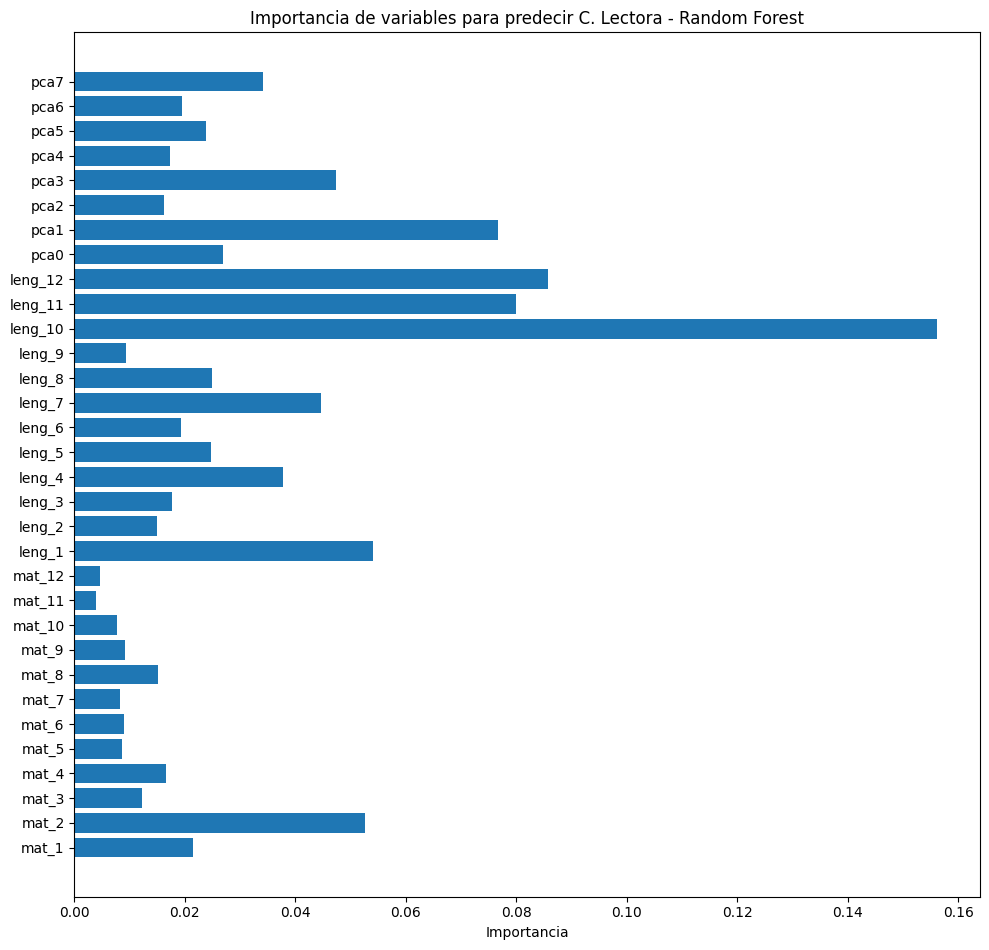

In [54]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_names = df_datos.drop(columns=['RUT', 'C. Lectora']).columns.tolist()

plt.figure(figsize=(10, len(feature_names)*0.3))
plt.barh(feature_names, importances)
plt.xlabel("Importancia")
plt.title("Importancia de variables para predecir C. Lectora - Random Forest")
plt.tight_layout()
plt.show()

In [55]:
top_indicators_df[top_indicators_df['index'].isin(['PC1', 'PC3'])]

,index,Top Indicator 1,Top Indicator 2,Top Indicator 3,Top Indicator 4,Top Indicator 5,Top Indicator 6,Top Indicator 7,Top Indicator 8,Top Indicator 9,Top Indicator 10,Top Indicator 11,Top Indicator 12,Top Indicator 13,Top Indicator 14,Top Indicator 15
0,PC1,Reemplazar conectores según la función que cum...,Distinguir el tema central en un texto no lite...,* Atribuir el propósito comunicativo de textos...,Inferir información del texto relacionando ide...,Inferir el significado de palabras a partir de...,Identificar datos de un texto relacionando inf...,"Inferir relaciones de finalidad, causa y conse...",Inferir el significado de palabras no familiar...,Inferir la moraleja de una fábula.,* Relacionar ideas que permiten comprender el ...,Inferir características de personajes en narra...,Resolver un problema que requiere calcular la ...,"Reconocer la función de ilustraciones, símbolo...",Reconocer la función de adjetivos en diversos ...,Inferir información (hechos) en textos no lite...
2,PC3,Relacionar secuencia de pasos en textos instru...,Identificar información explícita (hechos) en ...,Resolver un problema que requiere calcular la ...,* Relacionar ideas que permiten comprender el ...,Reconocer tipos de textos no literarios.,Interpretar lenguaje figurado en un texto no l...,Reemplazar conectores según la función que cum...,Establecer relaciones de correferencia textual.,Identificar información explícita de un texto.,Distinguir la idea principal de diversos textos.,Relacionar características del espacio narrati...,* Distinguir la idea principal de párrafos de ...,Distinguir la idea principal de párrafos de di...,Reconocer la función de sustantivos en diverso...,Distinguir el tema central de diversos textos.


### Predecir intervalos

In [56]:
from sklearn.ensemble import GradientBoostingRegressor
all_models = {}
for alpha in [0.05, 0.95]:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha) # regresion cuantil
    all_models[f"q {alpha}"] = gbr.fit(X_train, y_train)

y_lower = all_models["q 0.05"].predict(X_test)
y_upper = all_models["q 0.95"].predict(X_test)

# evaluamos si y_test se encuentra entre y_lower y y_upper
# y computamos el porcentaje de aciertos
n_correct = 0
for i in range(len(y_test)):
    if y_test.to_numpy()[i] >= y_lower[i] and y_test.to_numpy()[i] <= y_upper[i]:
        n_correct += 1
print(f'Porcentaje de aciertos: {n_correct / len(y_test) * 100:.2f}%')

y_diff_mean = np.mean(y_upper - y_lower)
y_diff_std = np.std(y_upper - y_lower)
print(f'Amplitud media del intervalo: {y_diff_mean:.2f}')
print(f'Std. de la amplitud del intervalo: {y_diff_std:.2f}')

Porcentaje de aciertos: 78.46%
Amplitud media del intervalo: 212.94
Std. de la amplitud del intervalo: 42.00


## Predecir Matemática

In [57]:
df_datos = df.drop(columns=['id', 'Nombre', 'Admisión', 'C. Lectora', 'Historia', 'Ciencias', 'M2']).copy()
print(f"Cantidad de filas antes de eliminar NaN: {df_datos.shape[0]}")
df_datos.dropna(inplace=True)  # eliminar filas con NaN
print(f"Cantidad de filas después de eliminar NaN: {df_datos.shape[0]}")

X = df_datos.drop(columns=['RUT', 'Matemática'])
y = df_datos['Matemática']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Cantidad de filas antes de eliminar NaN: 323
Cantidad de filas después de eliminar NaN: 322
X_train shape: (257, 32), y_train shape: (257,)
X_test shape: (65, 32), y_test shape: (65,)


In [58]:
modelos = {
    'Regresión Lineal': LinearRegression(),
    'Regresión Bayesiana': BayesianRidge(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'MLP (Neural Net)': MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=1000, random_state=42),
    'Ridge': Ridge(alpha=1.0, random_state=42)
}

resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    resultados.append({
        'Modelo': nombre,
        'RMSE': round(rmse, 2),
        'R²': round(r2, 3)
    })

df_resultados = pd.DataFrame(resultados)
print(df_resultados)

                Modelo   RMSE     R²
0     Regresión Lineal  88.87  0.496
1  Regresión Bayesiana  88.54  0.499
2        Random Forest  96.05  0.411
3    Gradient Boosting  92.51  0.454
4     MLP (Neural Net)  97.40  0.394
5                Ridge  88.15  0.504


/opt/homebrew/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


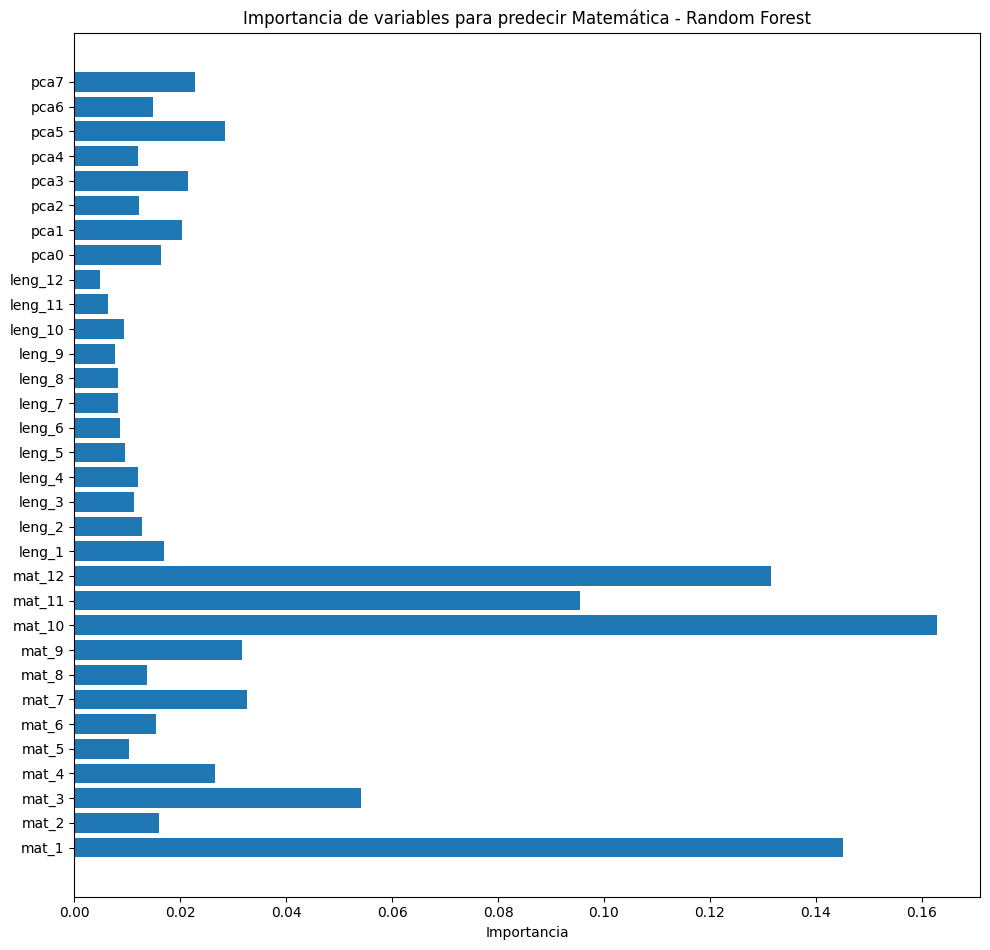

In [59]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_names = df_datos.drop(columns=['RUT', 'Matemática']).columns.tolist()

plt.figure(figsize=(10, len(feature_names)*0.3))
plt.barh(feature_names, importances)
plt.xlabel("Importancia")
plt.title("Importancia de variables para predecir Matemática - Random Forest")
plt.tight_layout()
plt.show()

In [60]:
top_indicators_df[top_indicators_df['index'].isin(['PC5', 'PC7'])]

,index,Top Indicator 1,Top Indicator 2,Top Indicator 3,Top Indicator 4,Top Indicator 5,Top Indicator 6,Top Indicator 7,Top Indicator 8,Top Indicator 9,Top Indicator 10,Top Indicator 11,Top Indicator 12,Top Indicator 13,Top Indicator 14,Top Indicator 15
4,PC5,Atribuir el propósito comunicativo de textos n...,Distinguir la idea principal de párrafos de di...,Identificar el orden de los acontecimientos en...,Distinguir la idea principal de diversos textos.,Reconocer tipos de textos no literarios.,Reconocer un conector que puede reemplazar a o...,"Reconocer la función de ilustraciones, símbolo...",Reconocer la función de ilustraciones en texto...,Resolver un problema que requiere plantear y d...,Distinguir el tema central de diversos textos ...,Reconocer al emisor en textos no literarios.,Inferir función de conectores en una oración.,Operar con información presentada en un pictog...,Inferir el significado de palabras no familiar...,Distinguir el tema central en un texto literario.
6,PC7,Identificar el par de figuras ubicadas en una ...,Reconocer diversos tipos de textos.,Distinguir el tema central de diversos textos ...,Inferir el significado de palabras a partir de...,"Inferir relaciones de finalidad, causa y conse...","Relacionar información (finalidades, causas y ...",Reconocer la función de algunos elementos de l...,* Distinguir el tema central de diversos texto...,* Distinguir la idea principal de párrafos de ...,Reconocer la función de sustantivos en diverso...,Inferir características de personajes en narra...,Inferir relaciones de causa y consecuencia en ...,Reconocer un conector que puede reemplazar a o...,Identificar informaciones en textos no literar...,Inferir el significado de palabras no familiar...


### Predecir intervalos

In [61]:
from sklearn.ensemble import GradientBoostingRegressor
all_models = {}
for alpha in [0.05, 0.95]:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha) # regresion cuantil
    all_models[f"q {alpha}"] = gbr.fit(X_train, y_train)

y_lower = all_models["q 0.05"].predict(X_test)
y_upper = all_models["q 0.95"].predict(X_test)

# evaluamos si y_test se encuentra entre y_lower y y_upper
# y computamos el porcentaje de aciertos
n_correct = 0
for i in range(len(y_test)):
    if y_test.to_numpy()[i] >= y_lower[i] and y_test.to_numpy()[i] <= y_upper[i]:
        n_correct += 1
print(f'Porcentaje de aciertos: {n_correct / len(y_test) * 100:.2f}%')

y_diff_mean = np.mean(y_upper - y_lower)
y_diff_std = np.std(y_upper - y_lower)
print(f'Diferencia media: {y_diff_mean:.2f}')
print(f'Diferencia std: {y_diff_std:.2f}')

Porcentaje de aciertos: 87.69%
Diferencia media: 247.46
Diferencia std: 71.85


## Predecir Ciencias

In [63]:
df_datos = df.drop(columns=['id', 'Nombre', 'Admisión', 'Matemática', 'Historia', 'C. Lectora', 'M2']).copy()
print(f"Cantidad de filas antes de eliminar NaN: {df_datos.shape[0]}")
df_datos.dropna(inplace=True)  # eliminar filas con NaN
print(f"Cantidad de filas después de eliminar NaN: {df_datos.shape[0]}")

X = df_datos.drop(columns=['RUT', 'Ciencias'])
y = df_datos['Ciencias']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

Cantidad de filas antes de eliminar NaN: 323
Cantidad de filas después de eliminar NaN: 152
X_train shape: (121, 32), y_train shape: (121,)
X_test shape: (31, 32), y_test shape: (31,)


In [68]:
modelos = {
    'Regresión Lineal': LinearRegression(),
    'Regresión Bayesiana': BayesianRidge(),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'MLP (Neural Net)': MLPRegressor(hidden_layer_sizes=(64, 32), max_iter=30000, random_state=42),
    'Ridge': Ridge(alpha=1.0, random_state=42)
}

resultados = []

for nombre, modelo in modelos.items():
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    resultados.append({
        'Modelo': nombre,
        'RMSE': round(rmse, 2),
        'R²': round(r2, 3)
    })

df_resultados = pd.DataFrame(resultados)
print(df_resultados)

                Modelo    RMSE     R²
0     Regresión Lineal   98.60  0.290
1  Regresión Bayesiana   96.48  0.320
2        Random Forest   91.49  0.389
3    Gradient Boosting  102.71  0.229
4     MLP (Neural Net)  170.21 -1.116
5                Ridge   96.31  0.322


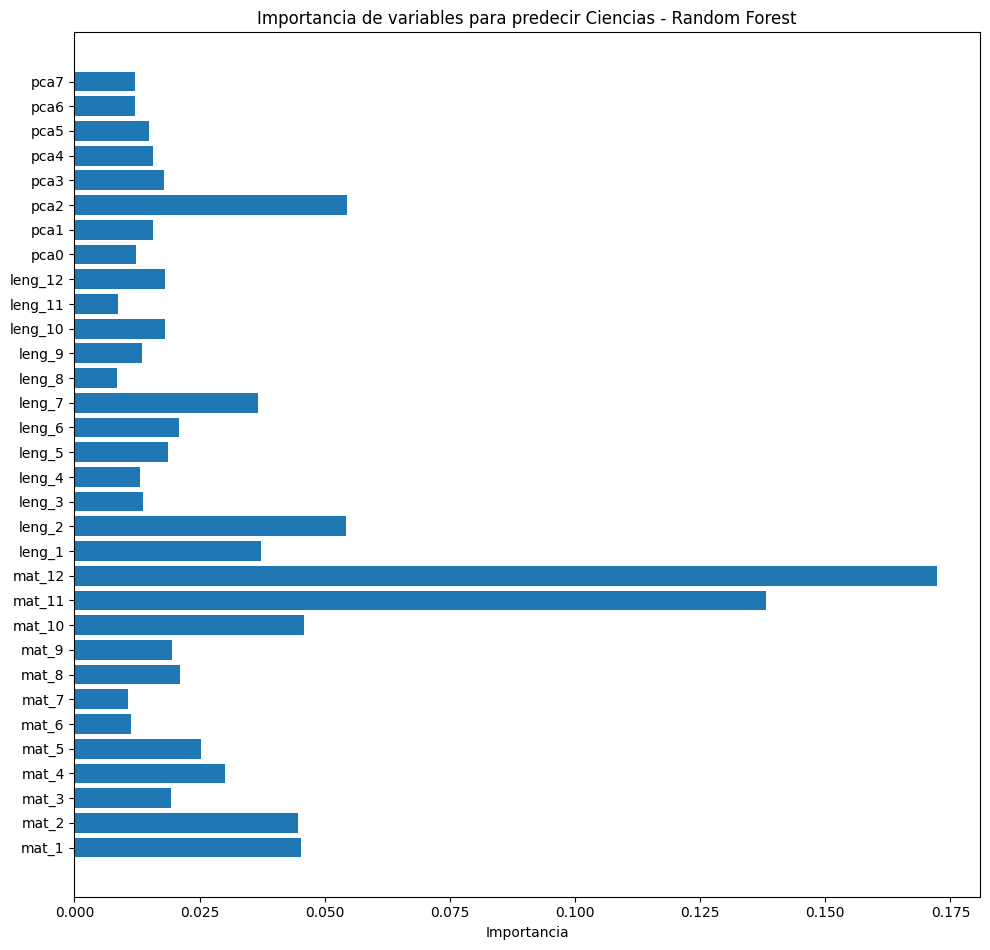

In [70]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feature_names = df_datos.drop(columns=['RUT', 'Ciencias']).columns.tolist()

plt.figure(figsize=(10, len(feature_names)*0.3))
plt.barh(feature_names, importances)
plt.xlabel("Importancia")
plt.title("Importancia de variables para predecir Ciencias - Random Forest")
plt.tight_layout()
plt.show()

In [71]:
from sklearn.ensemble import GradientBoostingRegressor
all_models = {}
for alpha in [0.05, 0.95]:
    gbr = GradientBoostingRegressor(loss="quantile", alpha=alpha) # regresion cuantil
    all_models[f"q {alpha}"] = gbr.fit(X_train, y_train)

y_lower = all_models["q 0.05"].predict(X_test)
y_upper = all_models["q 0.95"].predict(X_test)

# evaluamos si y_test se encuentra entre y_lower y y_upper
# y computamos el porcentaje de aciertos
n_correct = 0
for i in range(len(y_test)):
    if y_test.to_numpy()[i] >= y_lower[i] and y_test.to_numpy()[i] <= y_upper[i]:
        n_correct += 1
print(f'Porcentaje de aciertos: {n_correct / len(y_test) * 100:.2f}%')

y_diff_mean = np.mean(y_upper - y_lower)
y_diff_std = np.std(y_upper - y_lower)
print(f'Diferencia media: {y_diff_mean:.2f}')
print(f'Diferencia std: {y_diff_std:.2f}')

Porcentaje de aciertos: 77.42%
Diferencia media: 271.28
Diferencia std: 16.48
